# Machine Learning Modelling

In this notebook we will develop and fit machine learning models on the heart failure dataset. We will utilize the insights gained from both EDA as well as survival analysis as a means of selecting the features that the model will train upon.

EDA showed that this is an imbalanced problem where 2/3 of the dataset have not died following heart failure, thus, it will be important to use metrics that accurately reflect the performance of the model.

We will use the following models:
- Logistic Regression, this is a simple model which can serve as a baseline as well as a means of understanding whether the selected features are predictive of the outcome.
- Decision Tree, this is a slightly more complex model which can capture non-linear relationships between the features and the outcome.
- Random Forest, this is a more complex model which can capture non-linear relationships between the features and the outcome.

Based on the performance of the models, we will possible consider the use of a stacking ensemble model.

Lastly, we will track the experiments using MLFlow.

## Imports

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
import time
from functools import partial
import mlflow

In [41]:
sns.set_theme(
    style='whitegrid',
    rc={
        'figure.facecolor': '#fffed4',
        'axes.facecolor': '#fffed4',
        'grid.color': 'black',
        'grid.linestyle': '-',
        'grid.linewidth': 0.5,
        'axes.edgecolor': 'black',
        'axes.linewidth': 1.0,
        'xtick.color': 'black',
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'ytick.color': 'black',
        'font.family': 'Oxygen'
    }
)

## Data Loading

In [3]:
heart_data = pd.read_csv('heart_data_processed.csv')

In [5]:
selected_features = ['age', 'ejection_fraction', 'bp', 'serum_creatinine']
X = heart_data[selected_features]
y = heart_data['death']

In [6]:
X.head()

,age,ejection_fraction,bp,serum_creatinine
0,75.0,20,1,1.9
1,55.0,38,0,1.1
2,65.0,20,0,1.3
3,50.0,20,0,1.9
4,65.0,20,0,2.7


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [9]:
continuous_features = ['age', 'ejection_fraction','serum_creatinine']
scaler = RobustScaler()
X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])

## Setting ML Flow

In [10]:
mlflow.create_experiment('Heart Failure Death Prediction')

'287474788380947887'

In [12]:
mlflow.set_experiment('Heart Failure Death Prediction')

<Experiment: artifact_location='file:///Users/akhtar/Documents/Documents-Suhaib/Data%20Science%20Projects/heart_failure_analysis/mlruns/287474788380947887', creation_time=1700660900320, experiment_id='287474788380947887', last_update_time=1700660900320, lifecycle_stage='active', name='Heart Failure Death Prediction', tags={}>

## Model Training

We will begin by training the logistic regression model. To so do we will utilize grid search on the following hyperparameters:
- C, the inverse of the regularization strength
- penalty, the regularization type
- max_iter, the maximum number of iterations
- class_weight, balanced of None

As this is a medical classification problem, it will be vital for the model to not miss any positive cases, as this will prevent specific individuals from getting the treatment they need. Additionally, since all the patients in the dataset have heart failure, therefore misclassifying someone to succumb to heart failure is not as bad as misclassifying someone to survive heart failure. Thus, we will use the F1 score as the metric to optimize for.

In [176]:
def custom_recall(estimator, X, y):
    y_pred = estimator.predict(X)
    return recall_score(y, y_pred, average='binary')

### Logistic Regression

In [125]:
hp_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 200, 500, 1000],
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None]
}

In [126]:
# Define your custom precision scoring function with zero_division and additional arguments
def custom_precision(estimator, X, y_true):
    y_pred = estimator.predict(X)
    score = precision_score(y_true, y_pred, zero_division=0)
    return score

In [119]:
lr_model = LogisticRegression(random_state=42, solver='liblinear')
grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=hp_grid,
    cv=3,
    n_jobs=-1,
    refit=True,
    scoring='f1_weighted',
)

with mlflow.start_run(run_name='Logistic Regression - All HParams - liblinear - F1'):
    start = time.time()
    grid_search.fit(X_train, y_train)
    end = time.time()
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_probs = best_model.predict_proba(X_test)[:, 1]
    best_params = grid_search.best_params_

    mlflow.log_param('best_params', best_params)
    mlflow.log_metric('accuracy', best_model.score(X_test, y_test))
    mlflow.sklearn.log_model(best_model, 'lr_model')
    mlflow.log_metric('precision', precision_score(y_test, y_pred, average='weighted'))
    mlflow.log_metric('recall', recall_score(y_test, y_pred, average='weighted'))
    mlflow.log_metric('f1_score', f1_score(y_test, y_pred, average='weighted'))
    mlflow.log_metric('roc_score', roc_auc_score(y_test, y_probs))
    mlflow.log_metric('training_time', end-start)


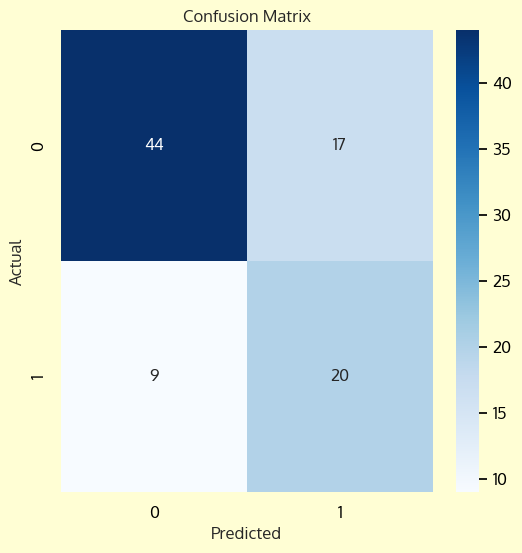

In [120]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [122]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.72      0.77        61
           1       0.54      0.69      0.61        29

    accuracy                           0.71        90
   macro avg       0.69      0.71      0.69        90
weighted avg       0.74      0.71      0.72        90



In [123]:
print(roc_auc_score(y_test, y_probs))

0.7625777275296778


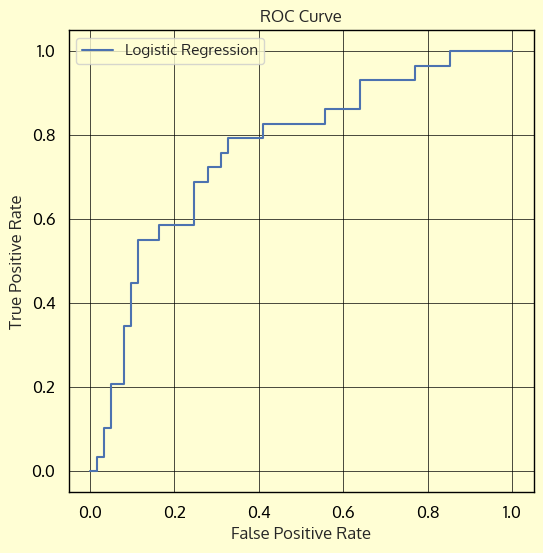

In [124]:
y_probs = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


#### Analysis

- The logistic regression achieves an average F1 of 72% on the test set.
- The model achieves a low precision score, however, it has obtained a decent recall of 69%.

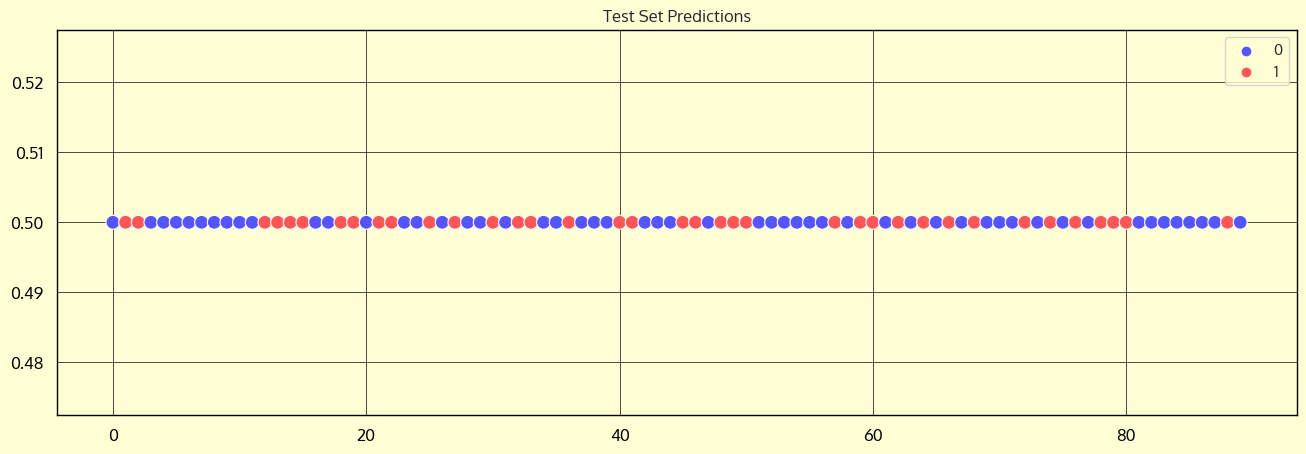

In [208]:
fig = plt.figure(figsize=(16, 5))
number_line = np.arange(0, len(y_pred))
constant = np.repeat(0.5, len(y_pred))
sns.scatterplot(x=number_line, y=constant, hue=y_pred, palette='seismic', s=100)
plt.title('Test Set Predictions')
plt.show()

### Decision Tree

In this section we will train a decision tree model. The decision tree contains many tuneable hyperparameters, an exhaustive grid search would not be feasible, therefore, to find the most optimal hyperparameters we will utilize grid search once more.

The hyperparameters we will tune are:
- max_depth, the maximum depth of the tree
- min_samples_split, the minimum number of samples required to split an internal node
- min_samples_leaf, the minimum number of samples required to be at a leaf node
- max_features, the number of features to consider when looking for the best split
- splitter
- criterion

In [168]:
param_dist = {
    "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "min_samples_split": [3, 4, 5, 6, 7, 8, 9, 10],
    "min_samples_leaf": [3, 4, 5, 6, 7, 8, 9],
    'splitter' : ['best', 'random'],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_features' : ['sqrt', 'log2', None]
}

In [177]:
dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_dist,
    cv=3,
    n_jobs=-1,
    refit=True,
    scoring=custom_recall,
)

with mlflow.start_run(run_name='Decision Tree - All HParams - Recall Custom'):
    start = time.time()
    grid_search.fit(X_train, y_train)
    end = time.time()
    best_model = grid_search.best_estimator_
    y_pred_dt = best_model.predict(X_test)
    y_probs_dt = best_model.predict_proba(X_test)[:, 1]
    best_params = grid_search.best_params_

    for key, value in best_params.items():
        mlflow.log_param(key, value)
    mlflow.log_metric('accuracy', best_model.score(X_test, y_test))
    mlflow.sklearn.log_model(best_model, 'dt_model')
    mlflow.log_metric('precision', precision_score(y_test, y_pred_dt, average='weighted'))
    mlflow.log_metric('recall', recall_score(y_test, y_pred_dt, average='weighted'))
    mlflow.log_metric('f1_score', f1_score(y_test, y_pred_dt, average='weighted'))
    mlflow.log_metric('roc_score', roc_auc_score(y_test, y_probs_dt))
    mlflow.log_metric('training_time', end-start)

In [178]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80        61
           1       0.57      0.55      0.56        29

    accuracy                           0.72        90
   macro avg       0.68      0.68      0.68        90
weighted avg       0.72      0.72      0.72        90



Text(0.5, 1.0, 'Confusion Matrix')

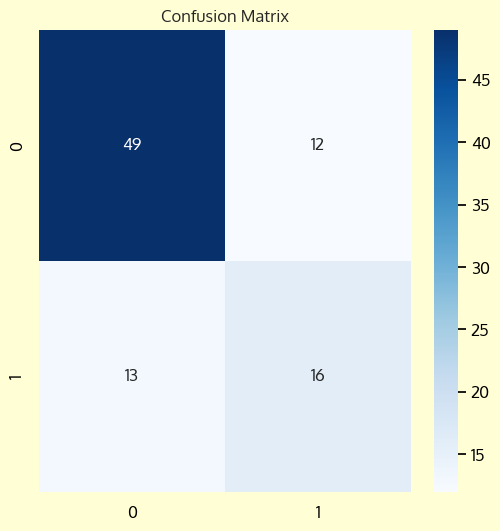

In [180]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')

In [181]:
recall_score(y_test, y_pred_dt, average='binary')

0.5517241379310345

In [209]:
roc_auc_score(y_test, y_probs_dt)

0.7080271339739966

In [199]:
correct_dt = y_pred_dt == y_test
correct_lr = y_pred == y_test

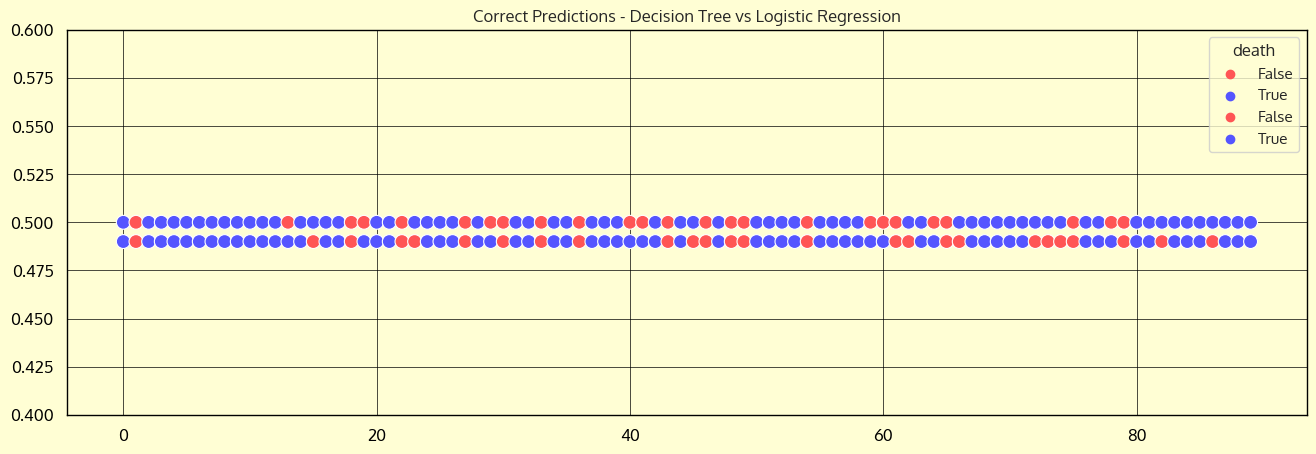

In [204]:
fig = plt.figure(figsize=(16, 5))
number_line = np.arange(0, len(y_pred_dt))
constant_dt = np.repeat(0.5, len(y_pred_dt))   
constant_lr = np.repeat(0.49, len(y_pred))
sns.scatterplot(x=number_line, y=constant_dt, hue=correct_dt, palette='seismic_r', s=100)
sns.scatterplot(x=number_line, y=constant_lr, hue=correct_lr, palette='seismic_r', s=100)
plt.ylim(0.4, 0.6)
plt.title('Correct Predictions - Decision Tree vs Logistic Regression')
plt.show()

#### Analysis

- The decision tree achieves an average F1 of 72% on the test set, which is quite similar to the logistic regression model.
- It however, achieves a much lower recall score of 55%, despite being optimized on the binary recall score.
- Viewing the correct/incorrect predictions of both models side by side shows that there are quite a few cases where the decision tree and logistic regression differ in their predictions. This fact can be utilized to build an ensemble model, that will make use of the predictions of both models to make a final prediction.

### Random Forest

In this section we will train a random forest model. The random forest contains many tuneable hyperparameters, an exhaustive grid search would not be feasible, therefore, to find the most optimal hyperparameters we will utilize an informed search mechanism that will function as follows:
- First the model will be trained using a few iterations of random search
- The hyperparameter space will be narrowed down by analysis of the performance.
- Depending on the size of the restricted hyperparameter space, either random search or grid search will be used to find the optimal hyperparameters.

In [212]:
param_dist = {
    'n_estimators' : np.arange(50, 1000, 50),
    'max_depth' : np.arange(2, 10, 1),
    'min_samples_split' : np.arange(2, 10, 1),
    'min_samples_leaf' : np.arange(2, 10, 1),
    'max_features' : [0.5, 0.6, 0.7, 0.8, 0.9],
    'bootstrap' : [True, False],
    'criterion' : ['gini', 'entropy']
}

In [213]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    cv=3,
    n_jobs=-1,
    refit=True,
    scoring=custom_recall,
    n_iter=1000,
    random_state=42
)

with mlflow.start_run(run_name='Random Forest - All HParams Random Search - Recall Custom'):

    start = time.time()
    random_search.fit(X_train, y_train)
    end = time.time()
    best_model = random_search.best_estimator_
    y_pred_rf = best_model.predict(X_test)
    y_probs_rf = best_model.predict_proba(X_test)[:, 1]
    best_params = random_search.best_params_

    for key, value in best_params.items():
        mlflow.log_param(key, value)
    mlflow.log_metric('accuracy', best_model.score(X_test, y_test))
    mlflow.sklearn.log_model(best_model, 'rf_model')
    mlflow.log_metric('precision', precision_score(y_test, y_pred_rf, average='weighted'))
    mlflow.log_metric('recall', recall_score(y_test, y_pred_rf, average='weighted'))
    mlflow.log_metric('f1_score', f1_score(y_test, y_pred_rf, average='weighted'))
    mlflow.log_metric('roc_score', roc_auc_score(y_test, y_probs_rf))
    mlflow.log_metric('training_time', end-start)

results = pd.DataFrame(random_search.cv_results_)

#### Hyperparameter Analysis

In [216]:
results = results.sort_values(by='mean_test_score', ascending=False)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
815,0.149302,0.005298,0.022863,0.000127,150,2,7,0.7,4,gini,False,"{'n_estimators': 150, 'min_samples_split': 2, ...",0.652174,0.681818,0.772727,0.702240,0.051290,1
903,1.341512,0.114614,0.087929,0.007626,650,7,8,0.8,2,gini,False,"{'n_estimators': 650, 'min_samples_split': 7, ...",0.608696,0.681818,0.772727,0.687747,0.067097,2
437,0.691346,0.078419,0.068728,0.003463,550,4,7,0.8,2,gini,False,"{'n_estimators': 550, 'min_samples_split': 4, ...",0.608696,0.681818,0.772727,0.687747,0.067097,2
648,0.628471,0.040474,0.044669,0.009741,250,7,6,0.8,2,gini,False,"{'n_estimators': 250, 'min_samples_split': 7, ...",0.608696,0.681818,0.772727,0.687747,0.067097,2
405,0.862870,0.025337,0.099307,0.003117,750,6,8,0.8,2,entropy,False,"{'n_estimators': 750, 'min_samples_split': 6, ...",0.608696,0.681818,0.772727,0.687747,0.067097,2


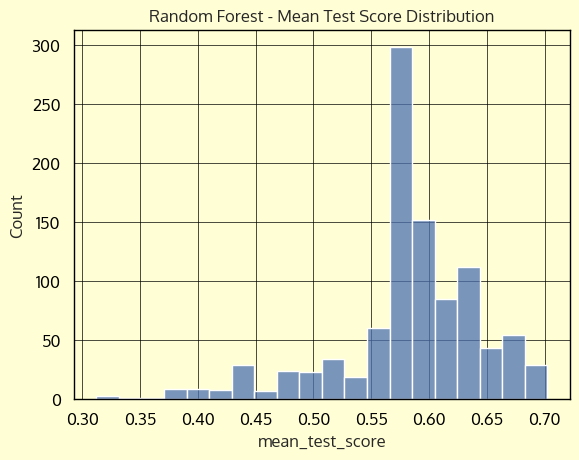

In [227]:
sns.histplot(results['mean_test_score'], bins=20)
plt.title('Random Forest - Mean Test Score Distribution')
plt.show()

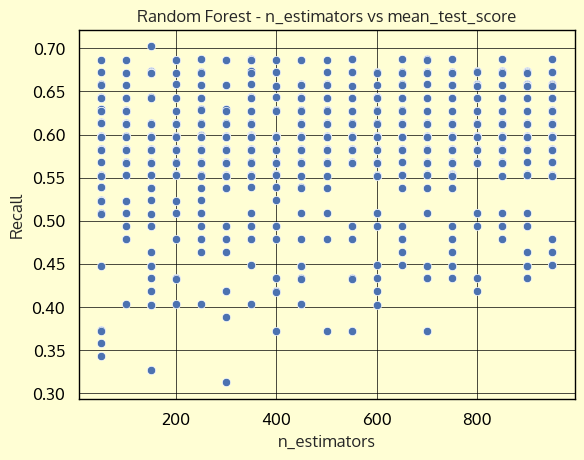

In [223]:
sns.scatterplot(x='param_n_estimators', y='mean_test_score', data=results)
plt.title('Random Forest - n_estimators vs mean_test_score')
plt.ylabel('Recall')
plt.xlabel('n_estimators')
plt.show()


- Generally speaking, trees above 800 are achieving higher scores on average.

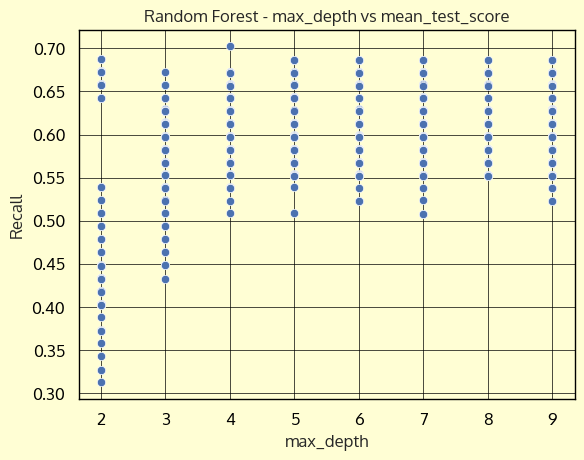

In [224]:
sns.scatterplot(x='param_max_depth', y='mean_test_score', data=results)
plt.title('Random Forest - max_depth vs mean_test_score')
plt.ylabel('Recall')
plt.xlabel('max_depth')
plt.show()

- The depths 6,7, and 8 seem to be the best performing depths for the model. 

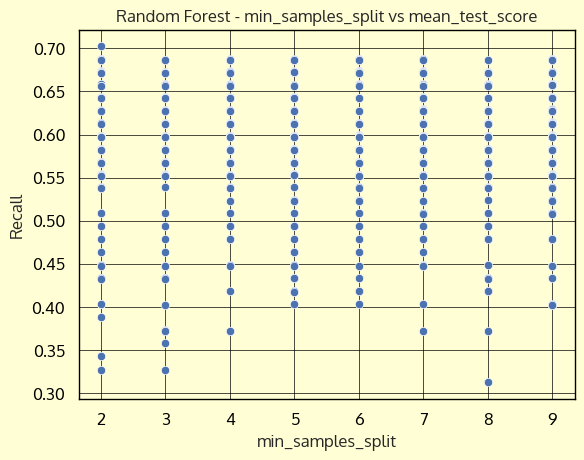

In [225]:
sns.scatterplot(x='param_min_samples_split', y='mean_test_score', data=results)
plt.title('Random Forest - min_samples_split vs mean_test_score')
plt.ylabel('Recall')
plt.xlabel('min_samples_split')
plt.show()

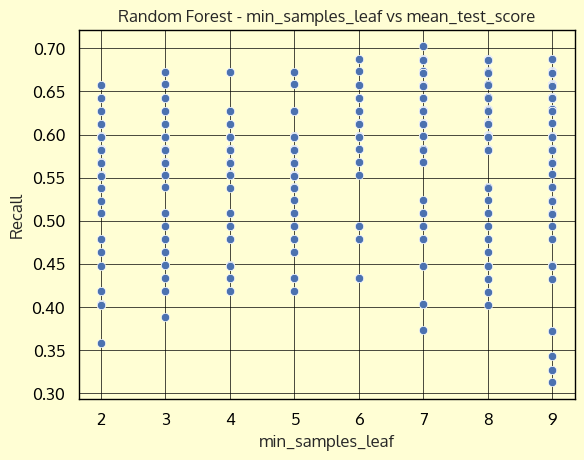

In [226]:
sns.scatterplot(x='param_min_samples_leaf', y='mean_test_score', data=results)
plt.title('Random Forest - min_samples_leaf vs mean_test_score')
plt.ylabel('Recall')
plt.xlabel('min_samples_leaf')
plt.show()

- At the least, 6,7 or 8, leaves per leaf seem to be the best performing.

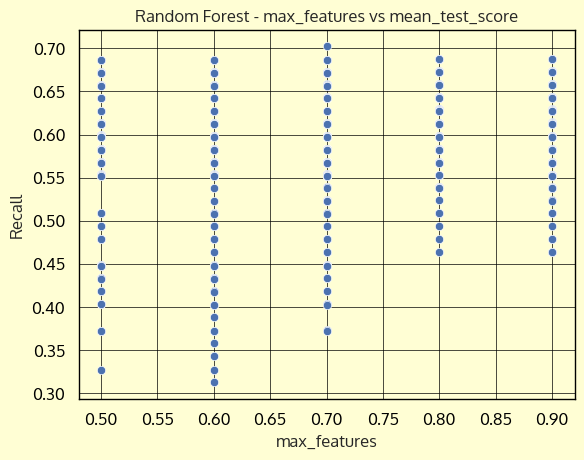

In [228]:
sns.scatterplot(x='param_max_features', y='mean_test_score', data=results)
plt.title('Random Forest - max_features vs mean_test_score')
plt.ylabel('Recall')
plt.xlabel('max_features')
plt.show()

- 0.7, 0.8, 0.9 for max feautres seem to be the best performing.s

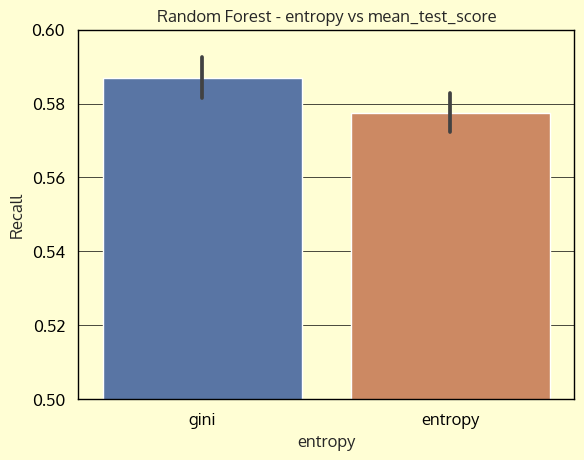

In [233]:
sns.barplot(x='param_criterion', y='mean_test_score', data=results)
plt.title('Random Forest - entropy vs mean_test_score')
plt.ylabel('Recall')
plt.ylim((0.5, 0.6))
plt.xlabel('entropy')
plt.show()

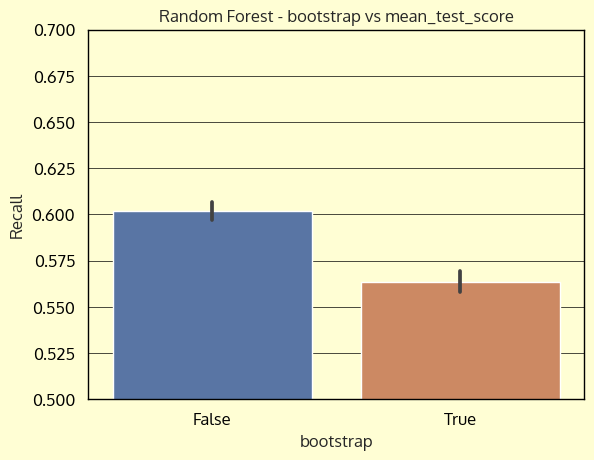

In [236]:
sns.barplot(x='param_bootstrap', y='mean_test_score', data=results)
plt.title('Random Forest - bootstrap vs mean_test_score')
plt.ylabel('Recall')
plt.ylim((0.5, 0.7))
plt.xlabel('bootstrap')
plt.show()

#### Refined Search

Following the hyperparameter analysis, the parameter space was narrowed down to 54 unique combinations. This is a small enough number to perform grid search on.

In [237]:
restricted_param_dist = {
    'max_depth' : [6, 7, 8],
    'min_samples_split' : [5, 6],
    'min_samples_leaf' : [6, 7, 8],
    'max_features' : [0.7, 0.8, 0.9],
    'criterion' : ['gini'],
    'bootstrap' : [False],
    'n_estimators' : [850],
}

In [238]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=restricted_param_dist,
    cv=3,
    n_jobs=-1,
    refit=True,
    scoring=custom_recall,
)

with mlflow.start_run(run_name='Random Forest - Restricted HParams Grid Search - Recall Custom'):

    start = time.time()
    grid_search.fit(X_train, y_train)
    end = time.time()
    best_model = grid_search.best_estimator_
    y_pred_rf = best_model.predict(X_test)
    y_probs_rf = best_model.predict_proba(X_test)[:, 1]
    best_params = grid_search.best_params_

    for key, value in best_params.items():
        mlflow.log_param(key, value)
    mlflow.log_metric('accuracy', best_model.score(X_test, y_test))
    mlflow.sklearn.log_model(best_model, 'rf_model')
    mlflow.log_metric('precision', precision_score(y_test, y_pred_rf, average='weighted'))
    mlflow.log_metric('recall', recall_score(y_test, y_pred_rf, average='weighted'))
    mlflow.log_metric('f1_score', f1_score(y_test, y_pred_rf, average='weighted'))
    mlflow.log_metric('roc_score', roc_auc_score(y_test, y_probs_rf))
    mlflow.log_metric('training_time', end-start)

In [239]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80        61
           1       0.58      0.48      0.53        29

    accuracy                           0.72        90
   macro avg       0.68      0.66      0.67        90
weighted avg       0.71      0.72      0.71        90



Unfortunately, the grid search did not yield any better results than the random search. This is most likely due to the fact that the analysis of the hyperparameters did not consider the interaction between the hyperparameters. Thus, we will use the hyperparameters found by the random search.

### Stacking Ensemble

In this section we will create a stacking ensemble of the decision tree and logistic regression model in hopes of improving the performance of the model.

In [332]:
#import sklearn load model
from joblib import load
rf = RandomForestClassifier(
    bootstrap=False,
    criterion='gini',
    max_depth=4,
    max_features=0.7,
    min_samples_leaf=7,
    min_samples_split=2,
    n_estimators=150,
    random_state=42,
)
dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=3,
    max_features=None,
    min_samples_leaf=3,
    min_samples_split=3,
    splitter='best',
)
lr = LogisticRegression(
    C=0.1,
    class_weight='balanced',
    max_iter=100,
    penalty='l2',
    solver='liblinear',
)

# rf.fit(X_train, y_train)
# dt.fit(X_train, y_train)
# lr.fit(X_train, y_train)

# print('Random Forest Recall: ', recall_score(y_test, rf.predict(X_test)))
# print('Decision Tree Recall: ', recall_score(y_test, dt.predict(X_test)))
# print('Logistic Regression Recall: ', recall_score(y_test, lr.predict(X_test)))

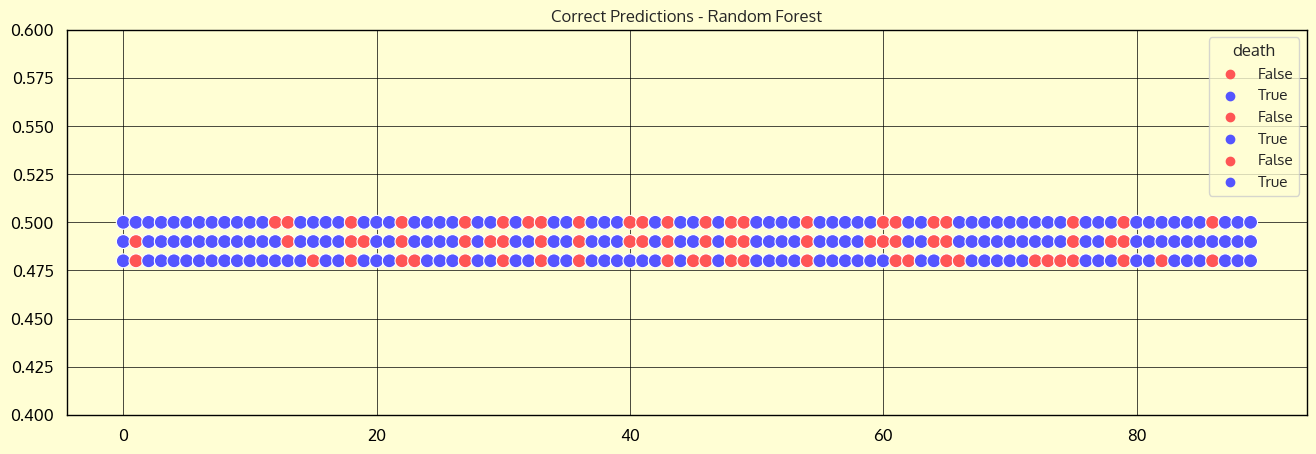

In [313]:
y_pred_lr = lr.predict(X_test)
y_pred_dt = dt.predict(X_test)
y_pred_rf = rf.predict(X_test)

correct_rf = y_pred_rf == y_test

fig = plt.figure(figsize=(16, 5))
number_line = np.arange(0, len(y_pred_rf))
constant_rf = np.repeat(0.5, len(y_pred_rf))
constant_dt = np.repeat(0.49, len(y_pred_dt))
constant_lr = np.repeat(0.48, len(y_pred_lr))
sns.scatterplot(x=number_line, y=constant_rf, hue=correct_rf, palette='seismic_r', s=100)
sns.scatterplot(x=number_line, y=constant_dt, hue=correct_dt, palette='seismic_r', s=100)
sns.scatterplot(x=number_line, y=constant_lr, hue=correct_lr, palette='seismic_r', s=100)
plt.ylim(0.4, 0.6)
plt.title('Correct Predictions - Random Forest')
plt.show()

In [333]:
classifiers = [
    ('Logistic Regression', lr),
    ('Decision Tree', dt),
    ('Random Forest', rf),
]


clf_stack = StackingClassifier(
    estimators=classifiers,
    cv=3,
    n_jobs=-1,
)

stack_grid = {
    'stack_method' : ['auto', 'predict_proba'],
    'passthrough' : [True, False],
}

grid_search = GridSearchCV(
    estimator=clf_stack,
    param_grid=stack_grid,
    cv=3,
    n_jobs=-1,
    refit=True,
    scoring=custom_recall,
)

with mlflow.start_run(run_name='Stacking Classifier - LogReg Meta - All HParams Grid Search - Recall Custom'):

    start = time.time()
    grid_search.fit(X_train, y_train)
    end = time.time()
    best_model = grid_search.best_estimator_
    y_pred_stack = best_model.predict(X_test)
    y_probs_stack = best_model.predict_proba(X_test)[:, 1]
    best_params = grid_search.best_params_

    for key, value in best_params.items():
        mlflow.log_param(key, value)
    mlflow.log_metric('accuracy', best_model.score(X_test, y_test))
    mlflow.sklearn.log_model(best_model, 'stack_model')
    mlflow.log_metric('precision', precision_score(y_test, y_pred_stack, average='weighted'))
    mlflow.log_metric('recall', recall_score(y_test, y_pred_stack, average='weighted'))
    mlflow.log_metric('f1_score', f1_score(y_test, y_pred_stack, average='weighted'))
    mlflow.log_metric('roc_score', roc_auc_score(y_test, y_probs_stack))
    mlflow.log_metric('training_time', end-start)



In [335]:
print(classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

           0       0.76      0.85      0.81        61
           1       0.59      0.45      0.51        29

    accuracy                           0.72        90
   macro avg       0.68      0.65      0.66        90
weighted avg       0.71      0.72      0.71        90



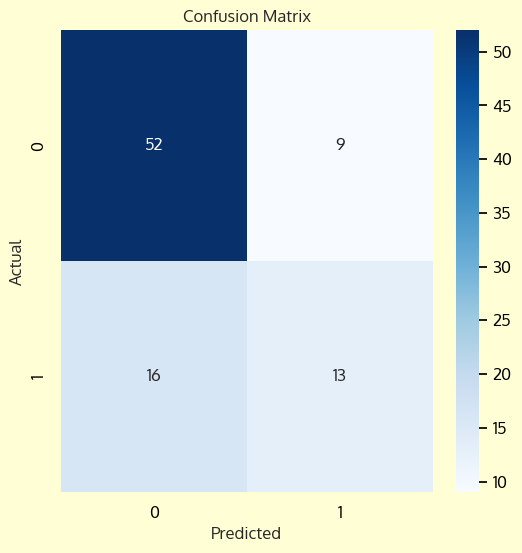

In [336]:
cm = confusion_matrix(y_test, y_pred_stack)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

- The stacking classifier didn't perform better than either of the base models.

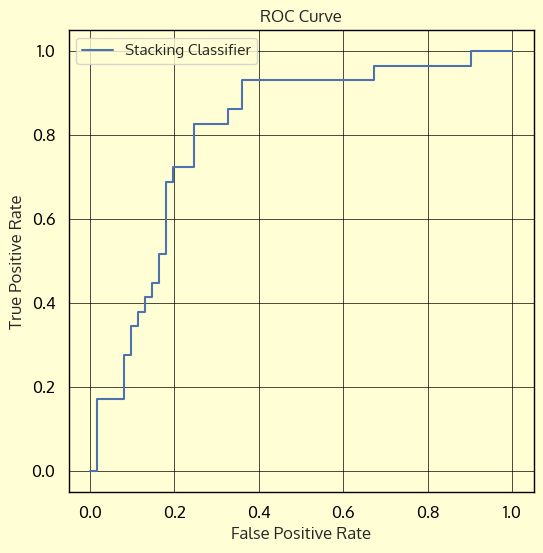

In [337]:
#roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_stack)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='Stacking Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Voting Classifier

The Stacking classifier didn't perform as expected, maybe a simple strategy of voting will perform better.

In [300]:
rf = RandomForestClassifier(
    bootstrap=False,
    criterion='gini',
    max_depth=4,
    max_features=0.7,
    min_samples_leaf=7,
    min_samples_split=2,
    n_estimators=150,
)
dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=3,
    max_features=None,
    min_samples_leaf=3,
    min_samples_split=3,
    splitter='best',
)
lr = LogisticRegression(
    C=0.1,
    class_weight='balanced',
    max_iter=100,
    penalty='l2',
    solver='liblinear',
)

In [324]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ('Logistic Regression', lr),
    ('Decision Tree', dt),
    ('Random Forest', rf),
]

voting_clf = VotingClassifier(
    estimators=estimators,
    voting='hard',
    n_jobs=-1,
)
with mlflow.start_run(run_name='Voting Classifier [LR, DT, RF] - Hard Voting - All HParams Grid Search - Recall Custom'):

    start = time.time()
    voting_clf.fit(X_train, y_train)
    end = time.time()
    y_pred_voting = voting_clf.predict(X_test)
    # y_probs_voting = voting_clf.predict_proba(X_test)[:, 1]

    mlflow.log_metric('accuracy', voting_clf.score(X_test, y_test))
    mlflow.sklearn.log_model(voting_clf, 'voting_model')
    mlflow.log_metric('precision', precision_score(y_test, y_pred_voting, average='weighted'))
    mlflow.log_metric('recall', recall_score(y_test, y_pred_voting, average='weighted'))
    mlflow.log_metric('f1_score', f1_score(y_test, y_pred_voting, average='weighted'))
    mlflow.log_metric('training_time', end-start)

In [326]:
print(classification_report(y_test, y_pred_voting))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        61
           1       0.62      0.62      0.62        29

    accuracy                           0.76        90
   macro avg       0.72      0.72      0.72        90
weighted avg       0.76      0.76      0.76        90



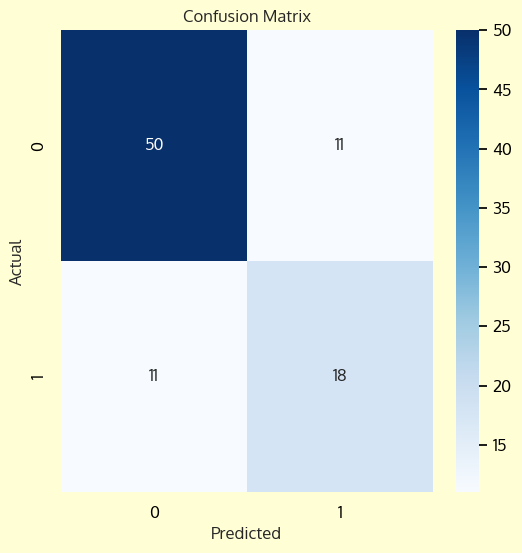

In [329]:
cm = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

(0.4, 0.6)

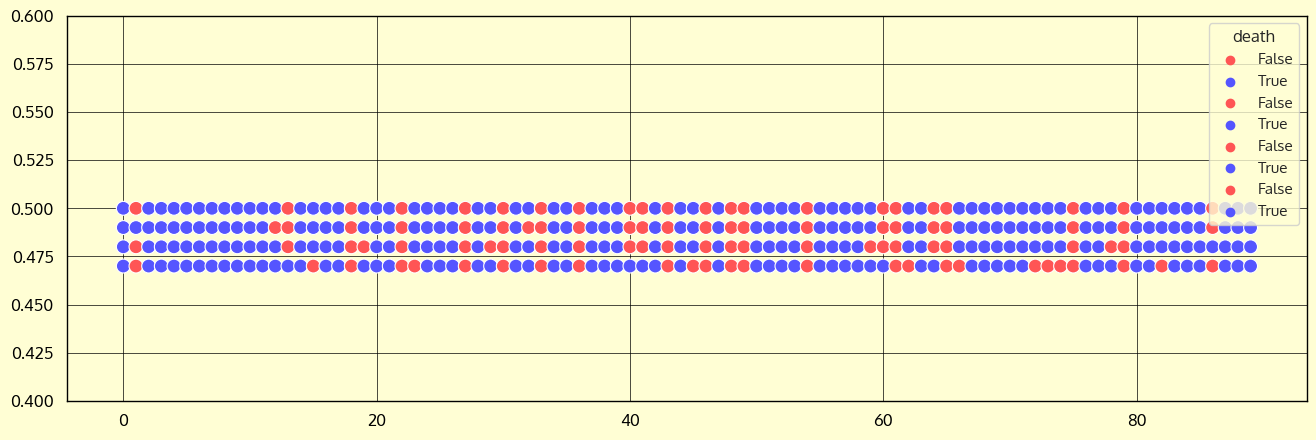

In [327]:
correct_voting = y_pred_voting == y_test

fig = plt.figure(figsize=(16, 5))
number_line = np.arange(0, len(y_pred_voting))
constant_voting = np.repeat(0.5, len(y_pred_voting))
constant_rf = np.repeat(0.49, len(y_pred_rf))
constant_dt = np.repeat(0.48, len(y_pred_dt))
constant_lr = np.repeat(0.47, len(y_pred_lr))
sns.scatterplot(x=number_line, y=constant_voting, hue=correct_voting, palette='seismic_r', s=100)
sns.scatterplot(x=number_line, y=constant_rf, hue=correct_rf, palette='seismic_r', s=100)
sns.scatterplot(x=number_line, y=constant_dt, hue=correct_dt, palette='seismic_r', s=100)
sns.scatterplot(x=number_line, y=constant_lr, hue=correct_lr, palette='seismic_r', s=100)
plt.ylim(0.4, 0.6)

In [328]:
correct_voting.sum()

68

#### Analysis

- The voting classifier with 'hard' voting achieves the highest F1 score of 76%, all while balancing the precision and recall, 
- It only predicts 2 less 'death' cases than the logistic regression model.